In [1544]:
import numpy as np
import math
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import time


class SAnnealing(object):

    def __init__(self, domain, step = 1, final_temperature=0.1, temperature = 100, alpha=0.95, equilibrium=10, time = 0, limited_decimals = 1):
        self.domain = domain
        self.step = step
        self.temperature = temperature
        self.final_temperature = final_temperature
        self.alpha = alpha
        self.equilibrium = equilibrium
        self.time = time
        self.limited_decimals = limited_decimals

    def cost_function(self, f, x):
        return f(x)

    def create_first_solution(self):
         return np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

    def count_decimals(num):
        """
        Devuelve el número de decimales que tiene un número flotante.
        """
        num_str = str(num)

        decimal_index = num_str.find('.')

        if decimal_index == -1:
            return 0
        else:
            return len(num_str) - decimal_index - 1

    def create_neighbor_solution(self, actual_solution):
        neighbor = actual_solution.copy()
        idx = np.random.randint(len(actual_solution))
        if neighbor[idx] == 0:
            neighbor[idx] = 1
        else:
            neighbor[idx] = 0
        if(ieee_mantissa_to_decimal(neighbor, 8) <= self.domain[0][1]  and ieee_mantissa_to_decimal(neighbor, 8) >= self.domain[0][0] and (count_decimals(ieee_mantissa_to_decimal(neighbor, 8)) <= self.limited_decimals)):
            return neighbor
            
        while(1):
            neighbor = actual_solution.copy()
            idx = np.random.randint(len(actual_solution))
            if neighbor[idx] == 0:
                neighbor[idx] = 1
            else:
                neighbor[idx] = 0
            if(ieee_mantissa_to_decimal(neighbor, 8) <= self.domain[0][1]  and ieee_mantissa_to_decimal(neighbor, 8) >= self.domain[0][0] and (count_decimals(ieee_mantissa_to_decimal(neighbor, 8)) <= self.limited_decimals)):
                break

        return neighbor


    def aceptance_probability(self, deltaE, temperature):
        try:
            r = math.exp(-deltaE/temperature)
        except OverflowError:
            r = float("inf") 
        return r


    def update_temperature(self, temperature):
        return self.alpha * temperature


    def fit(self, objetive):
        self.cost_ = []
        actual_solution = self.create_first_solution()
        best_solution = actual_solution.copy()
        epoch = 0
        number_tested_solution = 0
        aceptanced = 100
        inicio = time.time()
        while (self.temperature > self.final_temperature):
            number_worst_solution_acepted = 0
            i = 0
            while (i < self.equilibrium):
                random_solution = self.create_neighbor_solution(actual_solution)
                number_tested_solution += 1
                delta_E = self.cost_function(objetive, random_solution)[1] - self.cost_function(objetive, actual_solution)[1]
                if delta_E > 0:
                    actual_solution = random_solution.copy()
                else:
                    deg_deltaE = self.aceptance_probability(-delta_E, self.temperature)
                    if(np.random.uniform(0, 1) < deg_deltaE):
                        actual_solution = random_solution.copy()
                        number_worst_solution_acepted += 1
                x, y = self.cost_function(objetive, actual_solution)
                self.cost_.append((x,y))
                epoch_strlen = len(str(epoch))
                fin = time.time()
                total = fin - inicio
                sys.stderr.write('\r%0*d Epoch | Equilibrium %d | Temperature %.2f '
                                '| Actual solution %f | Cost function: %.2f | Aceptance : %.2f | Time: %f' 
                        %
                        (epoch_strlen, epoch+1, i+1, self.temperature, 
                        x, y, aceptanced, total))
                time.sleep(self.time)
                sys.stderr.flush()
                i += 1
                epoch += 1
            aceptanced = number_worst_solution_acepted * 100 /number_tested_solution
            self.temperature = self.update_temperature(self.temperature)

In [1545]:
def cubic_function(x):
    return x**3 - 60*x**2 + 900*x + 100

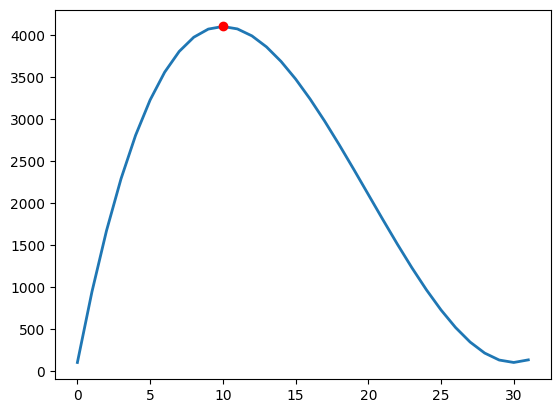

In [1546]:
x = np.arange(32)
y = np.array(list(map(cubic_function, x)))

# plot
fig, ax = plt.subplots()

ax.plot(x, y, linewidth=2.0)

# ax.set(xlim=(0, 32), xticks=np.arange(0, 32),
#        ylim=(0, 5000), yticks=np.arange(0, 5000))
plt.plot(10, 4100,'ro') 
plt.show()

In [1547]:
    def ieee_mantissa_to_decimal(mantissa_bits, exponent_bias):
        sign = -1 if mantissa_bits[0] else 1
        exponent = int(''.join(str(bit) for bit in mantissa_bits[1:exponent_bias+1]), 2) - (2 ** (exponent_bias-1) - 1)
        fraction = 1 + sum(mantissa_bits[exponent_bias+1+i] * 2**(-i-1) for i in range(len(mantissa_bits)-(exponent_bias+1)))
        return sign * fraction * 2**exponent

In [1548]:
def cubic_function(x):
    x = ieee_mantissa_to_decimal(x, 8)
    return (x, x**3 - 60*x**2 + 900*x + 100)

In [1584]:
sa = SAnnealing(domain=((0, 32),), step=1, final_temperature=0.1, temperature=500, alpha=0.95, equilibrium=10, time=0, limited_decimals=20)
sa.fit(cubic_function)

1670 Epoch | Equilibrium 10 | Temperature 0.10 | Actual solution 10.007673 | Cost function: 4100.00 | Aceptance : 0.18 | Time: 1.49787710

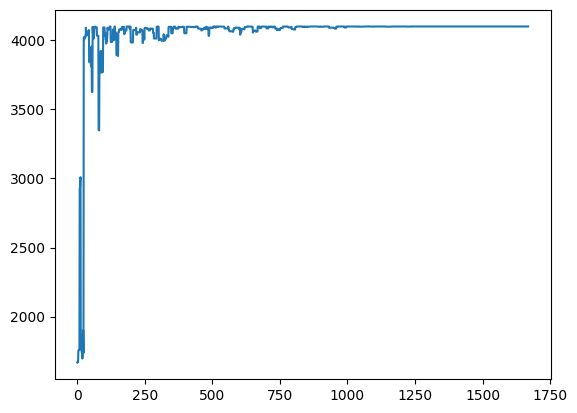

In [1550]:
plt.plot(range(len(sa.cost_)), [x[1] for x in sa.cost_ ])
plt.show()

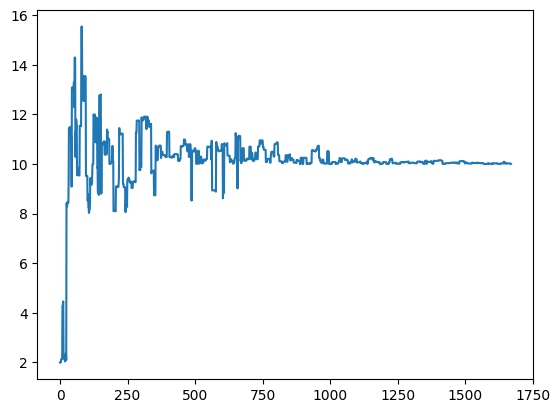

In [1551]:
plt.plot(range(len(sa.cost_)), [x[0] for x in sa.cost_ ])
plt.show()

In [1552]:
sa = SAnnealing(domain=((0, 32),), step=1, final_temperature=0.1, temperature=200, alpha=0.95, equilibrium=10, time=0, limited_decimals=5)
sa.fit(cubic_function)

1490 Epoch | Equilibrium 10 | Temperature 0.10 | Actual solution 7.968750 | Cost function: 3967.84 | Aceptance : 0.00 | Time: 1.98659679

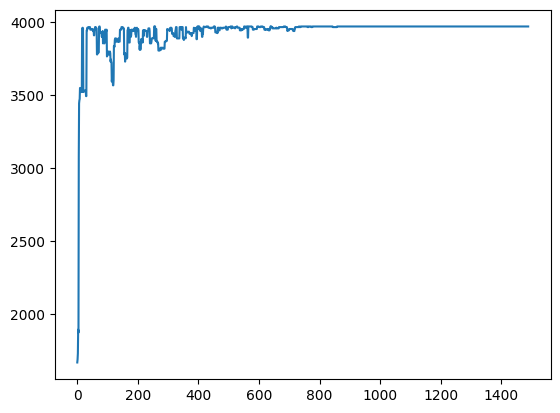

In [1553]:
plt.plot(range(len(sa.cost_)), [x[1] for x in sa.cost_ ])
plt.show()

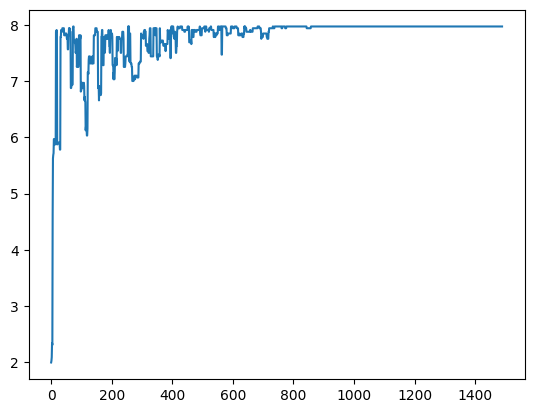

In [1554]:
plt.plot(range(len(sa.cost_)), [x[0] for x in sa.cost_ ])
plt.show()